# Numerical linear algebra, preconditioning, and the irreversibility of chaos

Preamble: Run the cells below to import the necessary Python packages

<!-- *This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

<!-- [Click here to open this notebook in Colab](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/numerical_linear_algebra_preconditioning.ipynb) -->
Open this notebook in Google Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/numerical_linear_algebra_preconditioning.ipynb)

In [1]:
## Preamble / required packages
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline


# Why numerical linear algebra?

Numerical linear algebra is essential because of its wide-ranging applications in optimization, machine learning, solving large systems of equations, and dynamical systems theory. Two major procedures dominate the subject in computational physics. The first is the inversion of large matrices, which includes methods for linear solving, analysis of conditioning, and LU factorization. The second is spectral decomposition, which underlies data analysis and the study of dynamical systems, with algorithms such as the QR algorithm playing a central role.

<!-- <img src="https://raw.githubusercontent.com/williamgilpin/cphy/refs/heads/main/resources/algebra1.png" style="max-width:50%; height:auto;"> -->

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/refs/heads/main/resources/gpu_scaling.png" style="max-width:50%; height:auto;">


# Linear problems

Local constitutive laws give rise to linear matrix equations. Common examples include:
+ Networks of resistors (Ohm's law), elastic solids (Hooke's law).
+ Linear perturbations off stable configurations (as occurs in protein folding)
+ $N$ columns denotes the number of particles (atoms, flow nodes, circuit connectsion, etc.)
+ $M$ rows denotes the number of equations relating the unknowns
+ $M < N$ is underdetermined, $M > N$ is overdetermined. However, this is only true if our matrix has full rank (however, if some variables are functions of others, or some equations are repeated, we can usually eliminate equations or variables to make the problem square)

Write a problem as a linear matrix equation
$$
    A \mathbf{x} = \mathbf{b}
$$

Solve for $\mathbf{x}$ using numerical tools to invert $A$

$$
    \mathbf{x} = A^{-1} \mathbf{b}
$$

Several issues can arise when attempting to find $A^{-1}$: 
+ A is too large to store in memory ($\sim\mathcal{O}(N^2)$ elements)
+ A is non-square (over- or under-determined system)
+ A is singular or very close to singular (two constraint equations are almost, but not quite the same)

## Finding the current through a circuit network

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/refs/heads/main/resources/circuit_diagram.png" style="max-width:40%; height:auto;">

Let $I_i$ denote the current through the $i^{th}$ loop in the circuit, and $V_j$ denote the voltage at the $j^{th}$ node in the circuit. Then, we can write down the following 3 x 3 matrix equation

$$
\begin{bmatrix}
R_1 + R_3 + R_4 & R_3 & R_4 \\
R_3 & R_2 + R_3 + R_5 & -R_5 \\
R_4 & -R_5 & R_4 + R_5 + R_6 
\end{bmatrix}
\begin{bmatrix}
I_1 \\
I_2 \\
I_3
\end{bmatrix}
=
\begin{bmatrix}
V_1 \\
V_2 \\
0
\end{bmatrix}
$$

We can now solve for the currents in the circuit using the inverse of the matrix on the left hand side

In [ ]:
# Some observed "data"
r1, r2, r3, r4, r5, r6 = np.random.random(6)
v1, v2 = np.random.random(2)


coefficient_matrix = np.array([
    [r1 + r3 + r4, r3, r4], 
    [r3, r2 + r3 + r5,  -r5],
    [r4, -r5, r4 + r5 + r6]
])
voltage_vector = np.array([v1, v2, 0])

# Solve the system of equations
# currents = np.linalg.solve(coefficient_matrix, voltage_vector)
currents = np.linalg.inv(coefficient_matrix) @ voltage_vector
# currents = np.matmul(np.linalg.inv(coefficient_matrix), voltage_vector)
# currents = np.dot(np.linalg.inv(coefficient_matrix), voltage_vector)
# currents = np.einsum("ij,j->i", np.linalg.inv(coefficient_matrix), voltage_vector)
print("Observed currents:", currents)

Observed currents: [ 0.21789554  0.09043251 -0.01222577]


## Matrices are collections of vectors

Suppose we have a matrix $A \in \mathbb{R}^{M \times N}$. We can think of it as a collection of $N$ column vectors $\vec{a}_i \in \mathbb{R}^M$.

$$
\vec{A} \equiv \begin{bmatrix}
   \vec{a}_1 & \vec{a}_2 & \cdots & \vec{a}_n
\end{bmatrix}
$$

Matrix multiplication corresponds to a linear combination of the columns of the matrix, and thus requires the addition of $N$ column vectors, each of which requires $M$ multiplications of individual scalar elements of a column vector by a scalar.

$$
\vec{A} \cdot \vec{x} = \begin{bmatrix} \vec{a}_1 & \vec{a}_2 & \cdots & \vec{a}_n \end{bmatrix} \begin{bmatrix} x_1 \\ \vdots \\ x_n \end{bmatrix}
   = \sum_{k=1}^n x_k \vec{a}_k,
$$

The **rank** of a matrix is the dimension of both its column space and its row space. Consequently, if $A \in \mathbb{R}^{M \times N}$, then $\text{rank}(A) \leq \min(M,N)$. Even if one directions is much larger than the other, the corresponding vectors correspond to a subspace of the larger space.

This motivates the **span** of a set of vectors, which is the collection of all points that can be reached through linear combinations of those vectors. When a matrix has deficient rank, its **nullspace** consists of nontrivial input vectors that map to zero, as in the case of projection operators. The **Rank–Nullity Theorem** states that  

$$
\dim(\text{Domain}) = \dim(\text{Image}) + \dim(\text{NullSpace}),
$$

which partitions the domain into the portion of space that is mapped into the image and the portion that collapses to zero. Finally, linear independence among the columns of a matrix ensures a trivial nullspace, implying that the input domain dimension matches the output image dimension, and the any linear transformation associated with that matrix preserves dimensionality.

### Thinking of matrices as dynamical systems

If $A$ is a square matrix, then it can be helpful to think of the action of the matrix as a dynamical system. We can generalize this to the case of non-square matrices or rank-deficient matrices by padding the matrix with zeros.

$\mathbf{x}_{t + 1} = A \mathbf{x}_{t}$

can be written as

$x^i_{t + 1} = \sum_i \mathbf{a}^{(r)} x^i_t$

where $\mathbf{a}^{(r)}$ is a row vector that corresponds to interactions with the other variables that affect the dynamics of $x^i$. 

A few initial insights that we can gain from this intuition are

1. **Rank-deficient dynamics**: If $A$ has deficient rank, then there exist directions (the nullspace) along which the dynamics collapse to zero, reducing the effective dimensionality of the system. Irreversible dynamics (like a projection) thus have a natural consequence in terms of the rank of a system. Extending this idea to multiple time-ordered operators, we can understand the origin of results like $A \in \mathbb{R}^{M \times N}$, $B \in \mathbb{R}^{N \times K}$, then $\operatorname {rank} (AB)\leq \min(\operatorname {rank} (A),\operatorname {rank} (B)).$

2. **Conservation and invariants**: If $A$ is full-rank andhas special structure (e.g., orthogonal, stochastic, or symmetric), it may conserve norms, probabilities, or other quantities across time steps.



## Consider the time complexity of matrix inversion

Given $A \in \mathbb{R}^{M \times N}$ and $\mathbf{b} \in \mathbb{R}^{N}$, we wish to solve $A \mathbf{x} = \mathbf{b}$

+ Best case scenario: $A$ is a diagonal matrix

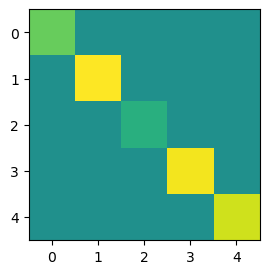

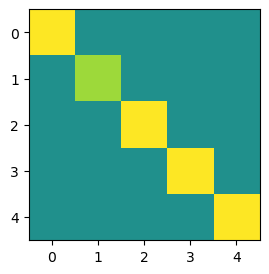

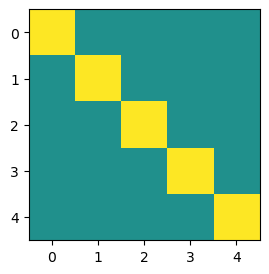

In [185]:
import numpy as np
diag_vals = np.random.randn(5)
ident = np.identity(5)
a = ident * diag_vals
plt.figure(figsize=(3,3))
plt.imshow(a, vmin=-1, vmax=1)

# # ## Create inverse directly
ident = np.identity(5)
ainv = ident * (1 / diag_vals)
plt.figure(figsize=(3,3))
plt.imshow(ainv, vmin=-1, vmax=1)


plt.figure(figsize=(3,3))
plt.imshow(a @ ainv, vmin=-1, vmax=1)

$A^{-1} A = I$

We can see that the time complexity of solving this problem is $O(N)$, because just have to touch each diagonal element once to invert it.


### Inverting an upper-triangular matrix


$$
\begin{bmatrix}
a_{11} & a_{12} & a_{13} & \cdots & a_{1N} \\
0 & a_{22} & a_{23} & \cdots & a_{2N} \\
0 & 0 & a_{33} & \cdots & a_{3N} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & a_{NN} \\
\end{bmatrix}
$$

Key: remember that inverting this matrix is equivalent to solving a system of equations

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/refs/heads/main/resources/triangular.png" style="max-width:40%; height:auto;">


A heuristic approach to inverting an upper-triangular matrix is to solve the easiest equation (the bottom rows) first, and then work our way up by substituting back into previous equations. The bottom row is already solved. Substituting it into the second-to-bottom row and rearranging to solve costs $2$ operations. Inserting the two solved rows into the next row up costs $3$ operations, and so on.If we count out these operations, they are equivalent to a cost of $\sim\mathcal{O}(N^2)$ to solve an upper-triangular matrix. 

<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Inversion of a full-rank square matrix

The naive inversion algorithm, Gauss-Jordan elimination, uses standard algebric manipulation to solve a system of equations.

$$
A = \begin{bmatrix}
1&3&1\\
1&1&-1\\
3&11&6
\end{bmatrix}, \quad \mathbf{b} = 
\begin{bmatrix}
9\\
1\\
35
\end{bmatrix}
$$
Can reduce by multiply by constants or adding two rows. For example, we subtract row 1 from row 2 in the first step
$$
\begin{bmatrix}
1&3&1&9\\
1&1&-1&1\\
3&11&6&35
\end{bmatrix}\to
\begin{bmatrix}
1&3&1&9\\
0&-2&-2&-8\\
3&11&6&35
\end{bmatrix}\to 
\begin{bmatrix}
1&3&1&9\\
0&-2&-2&-8\\
0&2&3&8
\end{bmatrix}
\to 
\begin{bmatrix}
1&3&1&9\\
0&-2&-2&-8\\
0&0&1&0
\end{bmatrix}
$$

We can write the Gauss-Jordan algorithm as a matrix multiplication
$$
\begin{bmatrix}
1&3&1\\
1&1&-1\\
3&11&6
\end{bmatrix} 
\begin{bmatrix}
1&0&0\\
-1&1&0\\
0&-1&1
\end{bmatrix}
 = 
\begin{bmatrix}
1&0&0\\
0&1&0\\
0&0&1
\end{bmatrix}
$$

Based on this, we can estimate the time complexity of Gauss-Jordan elimination as $O(N^3)$. It is the same as the time complexity of matrix multiplication.

<br>
<br>
<br>
<br>
<br>
<br>


## The condition number measures the sensitivity of matrix inversion

<!-- + Tells us how difficult a matrix will be to invert
+ A measure of how sensitive a matrix is to small perturbations
+ The condition number of a matrix is the ratio of the largest singular value to the smallest singular value
+ Matrix norm: $|| A ||_p = (\sum_{ij} |a_{ij}|^p)^{1/p}$. The familiar Frobenius norm is $p=2$ in this equation
+ Condition number: $\kappa \equiv || A ||_p || A^{-1} ||_p$ -->

The **condition number** of a matrix provides a measure of how difficult it is to invert and how sensitive it is to small perturbations. Formally, the condition number is defined as the ratio of the largest singular value to the smallest singular value. More generally, if we define the matrix norm as  
$$
    \|A\|_p = \left( \sum_{ij} |a_{ij}|^p \right)^{1/p},
$$  
with the familiar Frobenius norm corresponding to $p=2$. The condition number is given by  
$$
    \kappa \equiv \|A\|_p \, \|A^{-1}\|_p.
$$

In [38]:
def matrix_norm(A, p=2):
    """Compute the p-norm of a matrix A."""
    return np.sum(np.abs(A)**p)**(1/p)

def condition_number(A, p=2):
    """Compute the condition number of a matrix A"""
    return matrix_norm(A, p) * matrix_norm(np.linalg.inv(A), p)


<!-- + This next block of code creates an $N \times N$ matrix that initially corresponds to a matrix whose columns are all identical column vectors, $\mathbf{a}_1$. 

+ We then add an $N \times N$ matrix of random numbers drawn from the unit normal distribution, with mean $0$ and standard deviation $\epsilon$

$A = [\mathbf{a}_1\;\; \mathbf{a}_1 \;\;\mathbf{a}_1\;\; \mathbf{a}_1] + \epsilon E$

$ E \in \mathbb{R}^{N \times N}$

$ E_{ij} \sim \mathcal{N}(0, 1)$ -->

To understand the condition number, we construct an $N \times N$ matrix that initially has identical columns, each equal to a fixed column vector $\mathbf{a}_1 \in \mathbb{R}^N$. To this structured matrix, we add a small perturbation matrix of random numbers drawn from the standard normal distribution, scaled by a parameter $\epsilon$. Formally,  

$$
    A = [\mathbf{a}_1 \;\; \mathbf{a}_1 \;\; \mathbf{a}_1 \;\; \mathbf{a}_1] + \epsilon E,
$$  
where $E \in \mathbb{R}^{N \times N}$ and each entry is distributed as  
$$
    E_{ij} \sim \mathcal{N}(0,1).
$$

Text(0, 0.5, 'Condition number')

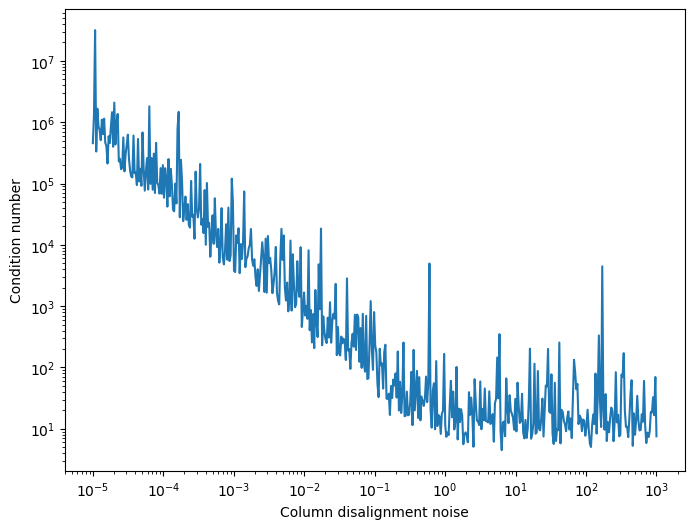

In [39]:
a1 = np.random.random(4)

noise_levels = np.logspace(-5, 3, 500)
all_condition_numbers = []
for noise_level in noise_levels:
    a = np.vstack(
        [
            a1 + np.random.normal(size=a1.shape) * noise_level, 
            a1 + np.random.normal(size=a1.shape) * noise_level, 
            a1 + np.random.normal(size=a1.shape) * noise_level, 
            a1 + np.random.normal(size=a1.shape) * noise_level
        ]
    )
    all_condition_numbers.append(condition_number(a))

plt.figure(figsize=(8, 6))
plt.loglog(noise_levels, all_condition_numbers)
plt.xlabel("Column disalignment noise")
plt.ylabel("Condition number")

We can see that as the perturbation matrix grows larger, the columns of the matrix become less and less similar to each other. Once the perturbation reaches the same scale as the original matrix itself, the columns become fully independent and the condition number stabilizes. We can therefore think of the condition number a a soft generalization of the rank of a matrix; the less linearly dependent the columns of a matrix, the smaller the condition number.

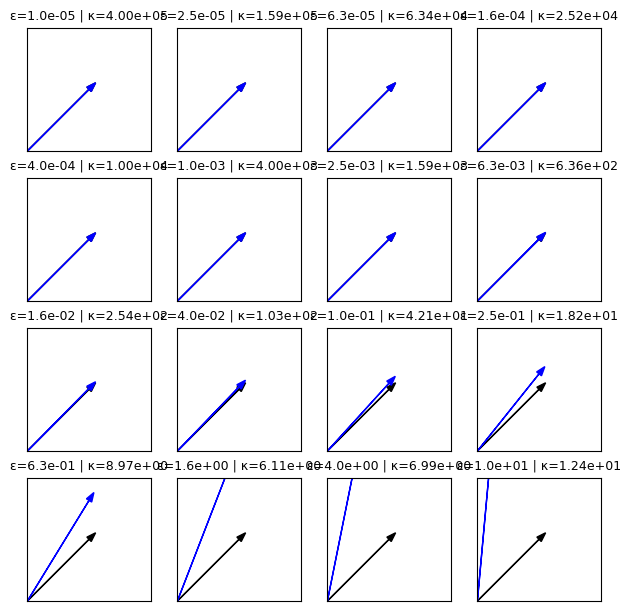

In [24]:
import numpy as np
import matplotlib.pyplot as plt

eps = np.logspace(-5, 1, 16)

fig, axes = plt.subplots(4, 4, figsize=(6, 6), constrained_layout=True)
axes = axes.ravel()

for ax, e in zip(axes, eps):
    A = np.array([[1, 1],
                  [1, 1 + e]])
    kappa = condition_number(A)

    # draw arrows
    ax.arrow(0, 0, 1, 1, head_width=0.1, color='black')
    ax.arrow(0, 0, 1, 1 + e, head_width=0.1, color='blue')

    # formatting
    ax.set_xlim(0, 2); ax.set_ylim(0, 2)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f"ε={e:.1e} | κ={kappa:.2e}", fontsize=9)

# Hide any unused axes (in case shape changes)
for j in range(len(eps), len(axes)):
    fig.delaxes(axes[j])

plt.show()

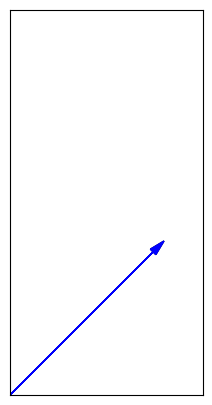

In [40]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# parameters
eps = np.logspace(-5, 0, 100)

# figure setup
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(0, 1.25)
ax.set_ylim(0, 2.5)
ax.set_aspect('equal', adjustable='box')
ax.set_xticks([]); ax.set_yticks([])

# initialize arrows as Line2D, but we'll redraw arrows manually each frame
arrow1, arrow2 = None, None

def init():
    global arrow1, arrow2
    if arrow1: arrow1.remove()
    if arrow2: arrow2.remove()
    arrow1 = ax.arrow(0, 0, 1, 1, head_width=0.05, head_length=0.1,
                      fc='black', ec='black', length_includes_head=True)
    arrow2 = ax.arrow(0, 0, 1, 1, head_width=0.05, head_length=0.1,
                      fc='blue', ec='blue', length_includes_head=True)
    ax.set_title("")
    return []

def update(frame: int):
    global arrow1, arrow2
    e = eps[frame]

    # clear previous arrows
    if arrow1: arrow1.remove()
    if arrow2: arrow2.remove()

    # new matrix and condition number
    A = np.array([[1, 1],
                  [1, 1 + e]])
    kappa = condition_number(A)

    # redraw arrows
    arrow1 = ax.arrow(0, 0, 1, 1, head_width=0.05, head_length=0.1,
                      fc='black', ec='black', length_includes_head=True)
    arrow2 = ax.arrow(0, 0, 1, 1 + e, head_width=0.05, head_length=0.1,
                      fc='blue', ec='blue', length_includes_head=True)

    # update title with sci-notation
    ax.set_title(f"ε={e:.1e} | κ={kappa:.2e}", fontsize=12)

    return []

anim = FuncAnimation(fig, update, frames=len(eps), init_func=init,
                     interval=60, blit=False, repeat=True)

HTML(anim.to_jshtml())

## Practical implications of ill-conditioned matrices

We next consider the practical implications of ill-conditioned matrices for numerical linear algebra. Below, we generate matrices of varying condition number using the same approach as in the previous section. We then solve a random linear system using a built-in solver in `numpy` and measure the error in the solution and the time it takes to solve the system.

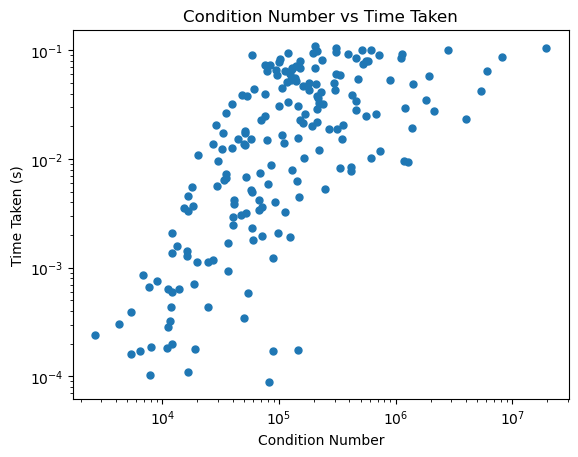

In [25]:
import time

sizes = np.arange(100, 2000, 10)
condition_numbers = []
times = []
for n in sizes:
    # Generate a random matrix and a random vector
    A = np.random.rand(n, n)
    b = np.random.rand(n)
    
    # Compute the condition number
    cond_num = np.linalg.cond(A)

    # Measure the time to solve the system
    start_time = time.time()
    np.linalg.solve(A, b)
    end_time = time.time()
    
    # Store the time taken and condition number
    condition_numbers.append(cond_num)
    times.append(end_time - start_time)

plt.figure()
plt.loglog(condition_numbers, times, '.', markersize=10)
plt.xlabel('Condition Number')
plt.ylabel('Time Taken (s)')
plt.title('Condition Number vs Time Taken')
plt.show()

Returning to our view of matrices as dynamical systems, below, we take 2 x 2 matrix that defines a dynamical system acting on points in the plane. We initialize a random point in the plane, and then initialize a second point a very small distance away from the first point. We then apply the matrix to both points for many timesteps, and we record the distance between the two points at each timestep.

In [43]:
a_well = np.array([
    [1, 1], 
    [1, 1 + 1e0], 
])

a_ill = np.array([
    [1, 1], 
    [1, 1 + 1e-14], 
])

print("The condition number of a_well is", np.linalg.cond(a_well))
print("The condition number of a_ill is", np.linalg.cond(a_ill))

The condition number of a_well is 6.854101966249685
The condition number of a_ill is 393638158031468.2


Our discrete dynamical system is given by
$$
    \mathbf{x}_{t+1} = A \mathbf{x}_t
$$
where $A$ is our matrix. We initialize a point in the plane, and then initialize a second point a very small distance away from the first point. We then apply the matrix to both points for many timesteps, and we record the distance between the two points at each timestep. We measure the distance between the two points as a function of time by calculating the *pairwise dispersion* of the points, which is the distance between each pair of points at each timestep,

$$
    D(t) = \sqrt{\sum_{i,j} (x_{i,t} - x_{j,t})^2}
$$

The pairwise dispersion is often used to measure mixing and diffusion among tracer particles in complex fluid flows.

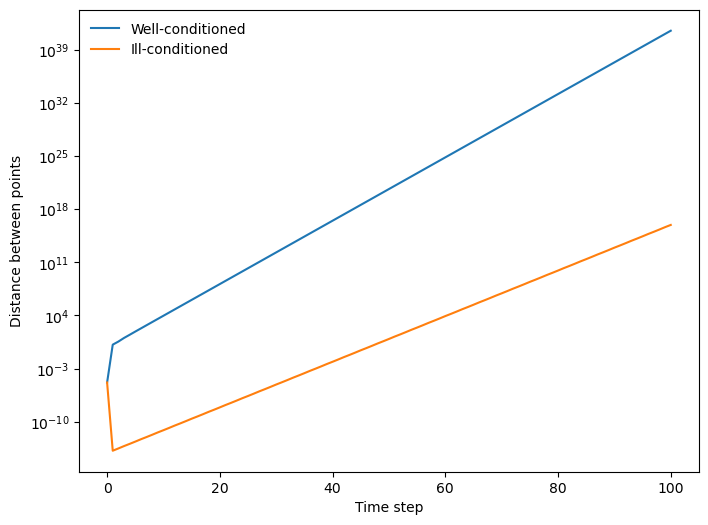

In [44]:
initial_condition = np.array([1, 1])
initial_condition_perturbed = initial_condition + 1e-5

# repeatedly apply the matrix to the initial condition and another one super close to it
all_points = [np.array([initial_condition, initial_condition_perturbed])]
for i in range(100):
    all_points.append(a_well @ all_points[-1].T)
# Calculate separation between the two points vs time
pairwise_dispersion = np.linalg.norm(np.diff(np.array(all_points), axis=1), axis=(1, 2))
plt.figure(figsize=(8, 6))
plt.semilogy(pairwise_dispersion, label="Well-conditioned")
plt.xlabel("Time step")
plt.ylabel("Distance between points")

# # repeatedly apply the matrix to the initial condition and another one super close to it
all_points = [np.array([initial_condition, initial_condition_perturbed])]
for i in range(100):
    all_points.append(a_ill @ all_points[-1].T)
# Calculate separation between the two points vs time
pairwise_dispersion = np.linalg.norm(np.diff(np.array(all_points), axis=1), axis=(1, 2))
plt.semilogy(pairwise_dispersion, label="Ill-conditioned")
plt.xlabel("Time step")
plt.ylabel("Distance between points")
plt.legend(frameon=False)

We can see that the spacing between the two points grows exponentially with time, but it grows more *slowly* under the action of the ill-conditioned matrix. Conceptually, the ill-conditioned matrix acts as if the two points are confined to a lower-dimensional space, and the dynamics pull them apart along fewer directions than for the higher-rank matrix. In a dynamical systems view of the matrix, the ill-conditioning would be associated with a slow manifold in the dynamics.

<br>
<br>
<br>
<br>


## What about the inverse of a matrix?

We can think of the inverse of a matrix as inverting the dynamics in time. If the forward dynamics are given by 

$$
    x_{t+1} = A x_t,
$$
then the inverse dynamics are given by 

$$
    x_{t-1} = A^{-1} x_t.
$$

/var/folders/79/zct6q7kx2yl6b1ryp2rsfbtc0000gr/T/ipykernel_57316/3673522601.py:10: RuntimeWarning: overflow encountered in matmul
  all_points.append(ainv_ill @ all_points[-1].T)
/Users/william/mamba/envs/cphy/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2819: RuntimeWarning: overflow encountered in multiply
  ret = sqrt(add.reduce((x.conj() * x).real, axis=axis))


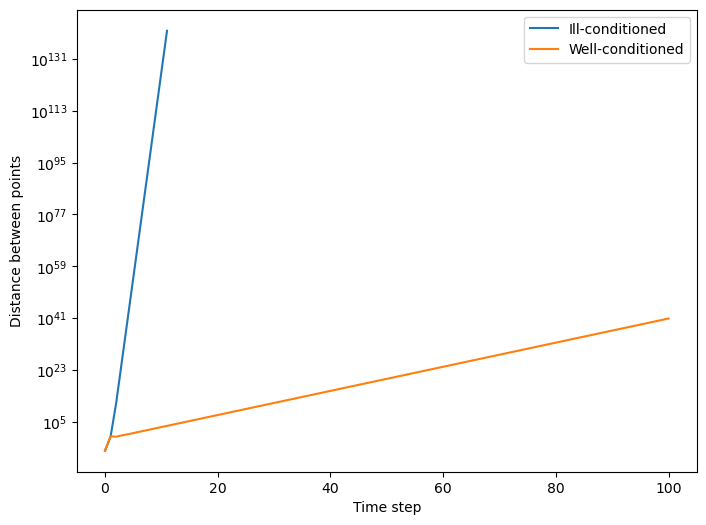

In [45]:
ainv_ill = np.linalg.inv(a_ill)
ainv_good = np.linalg.inv(a_well)

initial_condition = np.array([1, 1])
initial_condition_perturbed = initial_condition + 1e-5

# repeatedly apply the matrix to the initial condition and another one super close to it
all_points = [np.array([initial_condition, initial_condition_perturbed])]
for i in range(100):
    all_points.append(ainv_ill @ all_points[-1].T)
# Calculate separation between the two points vs time
pairwise_dispersion = np.linalg.norm(np.diff(np.array(all_points), axis=1), axis=(1, 2))
plt.figure(figsize=(8, 6))
plt.semilogy(pairwise_dispersion)
plt.xlabel("Time step")
plt.ylabel("Distance between points")

# repeatedly apply the matrix to the initial condition and another one super close to it
all_points = [np.array([initial_condition, initial_condition_perturbed])]
for i in range(100):
    all_points.append(ainv_good @ all_points[-1].T)
# Calculate separation between the two points vs time
pairwise_dispersion = np.linalg.norm(np.diff(np.array(all_points), axis=1), axis=(1, 2))
plt.semilogy(pairwise_dispersion)
plt.xlabel("Time step")
plt.ylabel("Distance between points")
plt.legend(["Ill-conditioned", "Well-conditioned"])


We can see that the inverse of the ill-conditioned matrix is much more sensitive to small perturbations in the input space

Why does this matter? Recall a least squares problem has the form

$$
    \mathbf{x} = A^{-1} \mathbf{b}
$$

If $A$ is ill-conditioned, then small perturbations in $\mathbf{b}$ can lead to large perturbations in the solution $\mathbf{x}$. Even if the least-squares problem is solvable, in principle, at finite precision, the solution is unstable.

In physical systems, unstable solutions due to ill-conditioning can lead to large fluctuations. For example, when solving for electrical current in Ohm's law ($I = R^{-1} V$), any small fluctuations in the voltage between a pair of nodes can lead to large fluctuations in the currents. This might occur, for example, when there are two similar paths between the same pair of nodes in a circuit. Likewise, in a Hookean elastic material ($X = K^{-1} F$), small perturbations in the applied forces can lead to large fluctuations in the displacements.

The perfectly-degenenerate (non-invertible) case in both system corresponds to the appearance of [zero modes](https://boulderschool.yale.edu/sites/default/files/files/boulder-2015a.pdf). However, even when there is a slight perturbation away from the degenerate case, we still expect to see large fluctuations in observable properties of the network.

<br>
<br>
<br>
<br>


## The curse of dimensionality

Under what conditions do we expect a matrix to become ill-conditioned? We will perform a numerical experiment to see how the condition number of a matrix scales with the dimensionality of the underlying system. We will generate a series of random matrices of varying dimensionality, and compute the condition number of each matrix.

<>:13: SyntaxWarning: invalid escape sequence '\k'
<>:13: SyntaxWarning: invalid escape sequence '\k'
/var/folders/79/zct6q7kx2yl6b1ryp2rsfbtc0000gr/T/ipykernel_57316/2799148162.py:13: SyntaxWarning: invalid escape sequence '\k'
  plt.loglog(nvals, 2*nvals**(1), '--', label="$\kappa \sim N$")


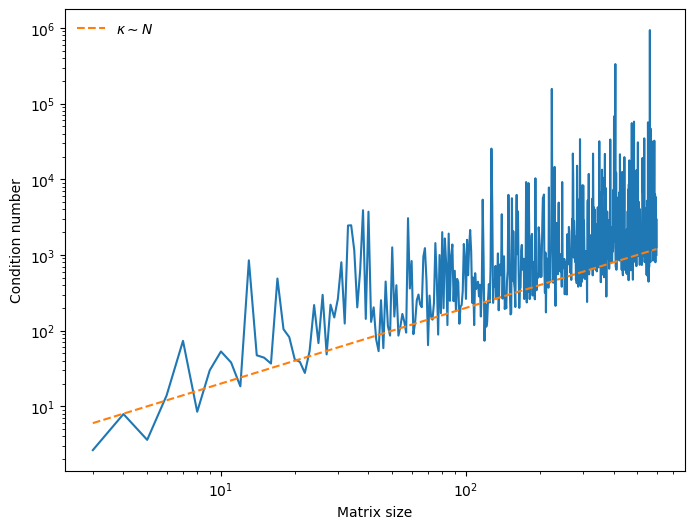

In [46]:
# a1 = np.random.random(4)

all_condition_numbers = []
all_norms = []
nvals = np.arange(3, 600)
for n in nvals:
    a = np.random.normal(size=(n, n))
    a /= n**2 ## Sanity check that we aren't getting naive scaling
    all_condition_numbers.append(np.linalg.cond(a))
    all_norms.append(matrix_norm(a))
plt.figure(figsize=(8, 6))
plt.loglog(nvals, all_condition_numbers)
plt.loglog(nvals, 2*nvals**(1), '--', label="$\kappa \sim N$")
plt.xlabel("Matrix size")
plt.ylabel("Condition number")
plt.legend(frameon=False)

We find that a random matrix has a condition number that scales as $\kappa \sim \mathcal{O}(N)$

<br>
<br>
<br>
<br>



### Concentration of measure

Random high-dimensional vectors tend to be nearly orthogonal. The code below calculates random Gaussian vectors with zero mean and unit variance in $N$ dimensions, and then calculates the angle between them


In [204]:
a1, a2 = np.random.randn(10), np.random.randn(10)
a1, a2 = a1 / np.linalg.norm(a1), a2 / np.linalg.norm(a2) # Convert to unit vectors
print(np.dot(a1, a2))

a1, a2 = np.random.randn(10000), np.random.randn(10000)
a1, a2 = a1 / np.linalg.norm(a1), a2 / np.linalg.norm(a2) # Convert to unit vectors
print(np.arccos(np.dot(a1, a2)))

0.49886931686533487
-0.012629821259598873


Estimate of asymptotic value: 1.58 +/- 0.05


Text(0, 0.5, 'Angle between random vectors')

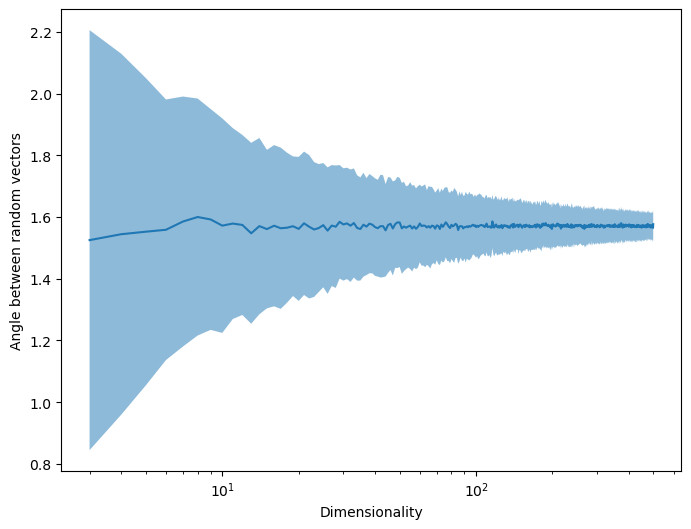

In [221]:
nvals = np.arange(3, 500)

all_angs = []
all_errs = []
for n in range(3, 500):

    # average across 100 replicates
    all_replicates = []
    for _ in range(400):
        a1 = np.random.randn(n)
        a2 = np.random.randn(n)
        ang = np.arccos(np.dot(a1, a2) / (np.linalg.norm(a1) * np.linalg.norm(a2)))
        all_replicates.append(np.abs(ang)) # abs because of negative angles
    all_angs.append(np.mean(all_replicates))
    all_errs.append(np.std(all_replicates))

print(f"Estimate of asymptotic value: {all_angs[-1]:.2f} +/- {all_errs[-1]:.2f}")

plt.figure(figsize=(8, 6))
plt.semilogx(nvals, all_angs)
plt.fill_between(nvals, np.array(all_angs) - np.array(all_errs), np.array(all_angs) + np.array(all_errs), alpha=0.5)
plt.xlabel("Dimensionality")
plt.ylabel("Angle between random vectors")


### The birthday paradox: A loose argument why large, random square matrices tend to be ill-conditioned

A matrix will be ill-conditioned in *any* pair of columns is close to collinear. Imagine a universe where every randomly-sampled vector is a unit vector with exactly one nonzero element. What is the probability that a matrix comprising a set of $N$ length-$N$ unit vectors are mutually orthogonal?

In [48]:
def sample_unit(n):
    a = np.random.randn(n)
    a0 = np.zeros(n)
    a0[np.argmax(a)] = 1
    return a0

sample_unit(10)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

We will start by taking the dot product of two random unit vectors in $N$ dimensions. We will repeat this process many times for each value of $N$, and plot the mean dot product as a function of $N$.

Text(0, 0.5, 'Mean dot product')

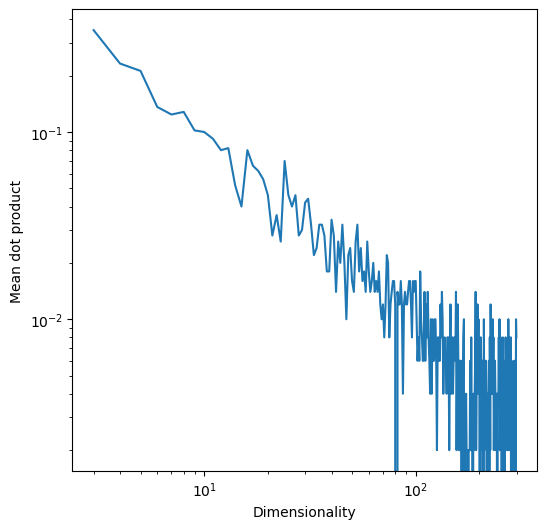

In [49]:
n_repeats = 500
nvals = np.arange(3, 300)
all_products_vals = []
for n in nvals:
    products = [sample_unit(n) @ sample_unit(n) for _ in range(n_repeats)]
    all_products_vals.append(np.mean(products))

plt.figure(figsize=(6, 6))
plt.loglog(nvals, all_products_vals)
# plt.loglog(nvals, 1 / nvals, '--')
plt.xlabel("Dimensionality")
plt.ylabel("Mean dot product")


Given just two vectors of length $N$, the probability of mutual orthogonality is
$$
P_{ortho} = \bigg(1\bigg) \bigg(\dfrac{N -1}{N}\bigg) = \bigg(\dfrac{N}{N}\bigg) \bigg(\dfrac{N -1}{N}\bigg)
$$
As $N \to \infty$, the probability of two vectors being orthogonal goes to zero as $\sim\mathcal{O}(1/N)$. We can see this in the plot above.

<br>
<br>
<br>
<br>
<br>



Now, given $N$ vectors, the probability of mutual orthogonality is
$$
P_{ortho} =\dfrac{N!}{N^N}
$$

Stirling's approximation: at large $N$, $N! \sim {\sqrt {2\pi N}}\left({\frac {N}{e}}\right)^{N}$
$$
P_{ortho} \sim \sqrt{2\pi N}e^{-N}
$$

The exponential term dominates at large $N$, and so the odds of getting lucky and having an invertible matrix vanish exponentially with $N$. In this case, the condition number diverges towards infinity.

For random continuous matrices, large matrices have a vanishing probability of being truly singular (you never draw the same multivariate sample twice), but their condition number grows quickly making them "softly" singular


Text(0, 0.5, 'Probability')

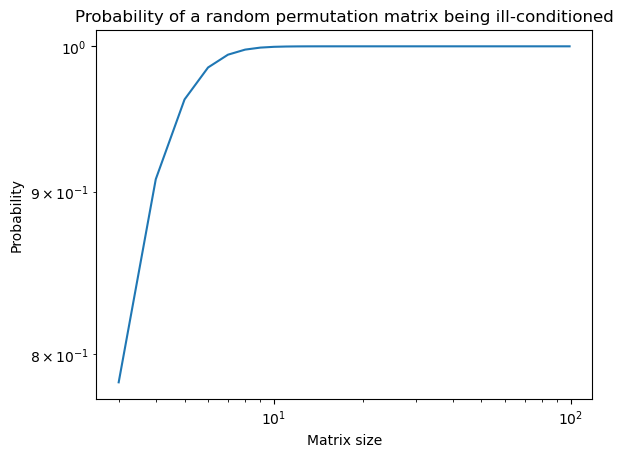

In [266]:
nvals = np.arange(3, 100)
plt.loglog(nvals, 1 - np.sqrt(2 * np.pi * nvals) * np.exp(-nvals))
plt.title("Probability of a random permutation matrix being ill-conditioned")
plt.xlabel("Matrix size")
plt.ylabel("Probability")

# Consequences of the curse of dimensionality

### The Johnson–Lindenstrauss lemma

A small set of points in a high-dimensional space can be embedded into a space of much lower dimension in such a way that distances between the points are nearly preserved. We can therefore use random projections to reduce the dimensionality of a dataset $X \in \mathbb{R}^{N \times D}$ to $X' \in \mathbb{R}^{N \times d}$ where $d \ll D$, and expect that distances between points in the low-dimensional space are similar to distances between points in the high-dimensional space.

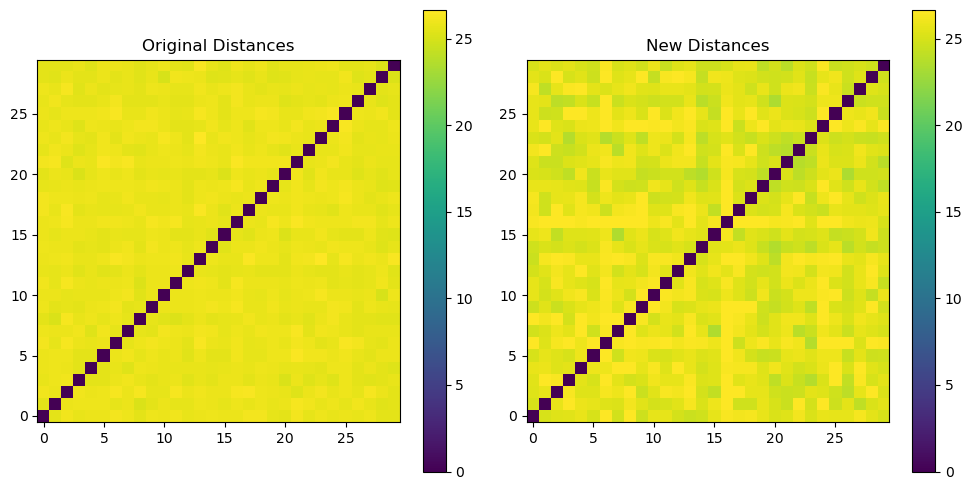

True
True


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Generate a set of high-dimensional vectors (e.g., 1000-dimensional)
num_points = 30
dim = 4000
X = np.random.rand(num_points, dim)

# Define the reduced dimension and target epsilon
new_dim = 500 
epsilon = 0.5

# Create a random projection matrix
projection_matrix = np.random.randn(new_dim, dim) / np.sqrt(new_dim)

# Project the high-dimensional vectors into the lower-dimensional space
X_new = X.dot(projection_matrix.T)

# Compute pairwise distances in the original and reduced spaces
dist_original = np.linalg.norm(X[:, None, :] - X[None, :, :], axis=-1)
dist_new = np.linalg.norm(X_new[:, None, :] - X_new[None, :, :], axis=-1)

# Step 6: Plot the original and new distances
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(dist_original, origin='lower', vmin=np.min(dist_original), vmax=np.max(dist_original))
plt.title('Original Distances')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(dist_new,  origin='lower', vmin=np.min(dist_original), vmax=np.max(dist_original))
plt.title('New Distances')
plt.colorbar()
plt.tight_layout()
plt.show()


# Check that the distances are approximately preserved to within epsilon
print(np.all((1 - epsilon) * dist_original <= dist_new))
print(np.all(dist_new <= (1 + epsilon) * dist_original))

## Condition number and the irreversibility of chaos

The Lorenz equations are a set of three coupled nonlinear ordinary differential equations that exhibit a transition to chaos,

$$
\begin{aligned}
\dot{x} &= \sigma (y-x) \\
\dot{y} &= x (\rho - z) - y \\
\dot{z} &= x y - \beta z
\end{aligned}
$$




where $\sigma$, $\rho$, and $\beta$ are parameters. These equations exhibit chaotic dynamics when $\sigma = 10$, $\rho = 28$, and $\beta = 8/3$. The degree of chaos can be varied by changing the parameter $\rho$.

We can linearize these equations by computing the Jacobian matrix, which is the matrix of all first-order partial derivatives of the system. The Jacobian matrix is


$$
\mathbb{J}(\mathbf{x}) =  \dfrac{d \mathbf{\dot{x}}}{d \mathbf{x}} = \begin{bmatrix}
-\sigma & \sigma & 0 \\
\rho - z & -1 & -x \\
y & x & -\beta
\end{bmatrix}
$$

Notice how, unlike a globally linear dynamical system, the Jacobian matrix $\mathbb{J}(\mathbf{x})$ is a function of the state vector $\mathbf{x}$. This means that the linearization of the system is only valid for a small region of state space around the point $\mathbf{x}$.

We can use the linearization of this system to create a simple finite-differences integration scheme. The linearized system is

$$
\mathbf{x}_{t+1} = \mathbf{x}_t + \Delta t\, \mathbb{J}(\mathbf{x}_t) \mathbf{x}_t 
$$

or, equivalently,

$$
\mathbf{x}_{t+1} = \left( \mathbb{I} + \Delta t\, \mathbb{J}(\mathbf{x}_t) \right) \mathbf{x}_t
$$

where $\mathbb{I}$ is the identity matrix.

We will see more sophisticated integration schemes later in the course, but this particular update rule in this case is a linear scheme with a forward update rule.

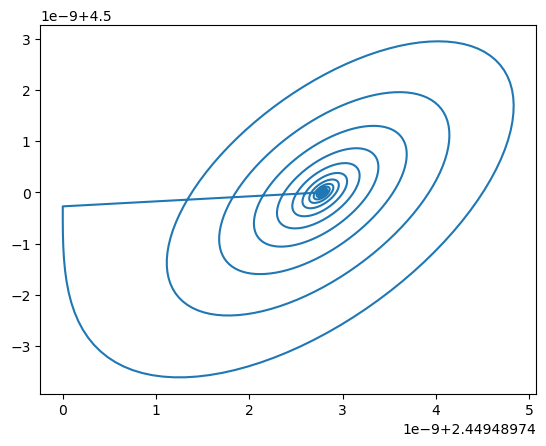

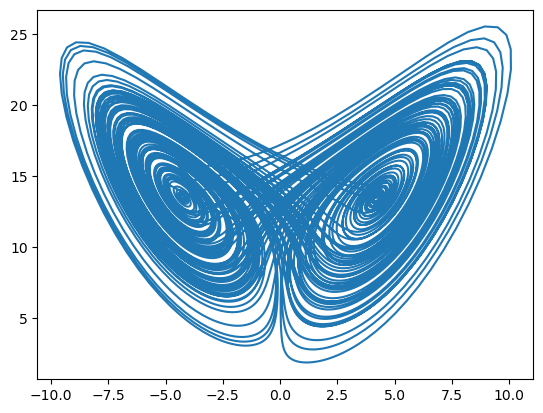

In [50]:
class Lorenz:
    """
    The Lorenz equations describe a chaotic system of differential equations.
    """
    def __init__(self, sigma=10, rho=28, beta=8/3):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta

    def rhs(self, X):
        """Returns the right-hand side (vector time derivative) of the Lorenz equations."""
        x, y, z = X # Argument unpacking
        return np.array([
            self.sigma * (y - x), 
            x * (self.rho - z) - y, 
            x * y - self.beta * z
        ])
    
    def jacobian(self, X):
        """Returns the Jacobian of the Lorenz equations."""
        x, y, z = X
        return np.array([
            [-self.sigma, self.sigma, 0], 
            [self.rho - z, -1, -x], 
            [y, x, -self.beta]
        ])
    
    def integrate(self, x0, t0, t1, dt):
        """
        Integrate using the jacobian and forward euler
        """
        x = x0
        all_x = [x]
        all_t = [t0]
        while t0 < t1:
            jac = self.jacobian(x) # because it's nonlinear we need to recompute at each step
            x += jac @ x * dt
            t0 += dt
            all_x.append(x.copy())
            all_t.append(t0)
        return np.array(all_x), np.array(all_t)
    


# A parameter value that doesn't exhibit chaos
eq = Lorenz(rho=10)
x0 = np.array([2.44948974, 2.44948974, 4.5]) 
x_nonchaotic, all_t = eq.integrate(x0, 0., 100., 0.01)
plt.figure()
plt.plot(x_nonchaotic[:, 0], x_nonchaotic[:, 2])

# # A parameter value that exhibits chaos
eq = Lorenz()
x0 = np.array([-5.0,  -5.0, 14.4]) # pick initial condition on the attractor
x_chaotic, all_t = eq.integrate(x0, 0., 100., 0.01)
plt.figure()
plt.plot(x_chaotic[:, 0], x_chaotic[:, 2])




## The condition number

Now we can evaluate the condition number of the Jacobian matrix $\mathbb{J}(\mathbf{x})$ at a particular point $\mathbf{x}$. The condition number is defined as

$$
\kappa(\mathbf{x}) = || \mathbb{J}(\mathbf{x}) || \, || \mathbb{J}^{-1}(\mathbf{x}) ||
$$

Because the system is not Hamiltonian, we cannot simplify this expression using the eigenvalues of the Jacobian matrix.



Text(0, 0.5, 'Condition number')

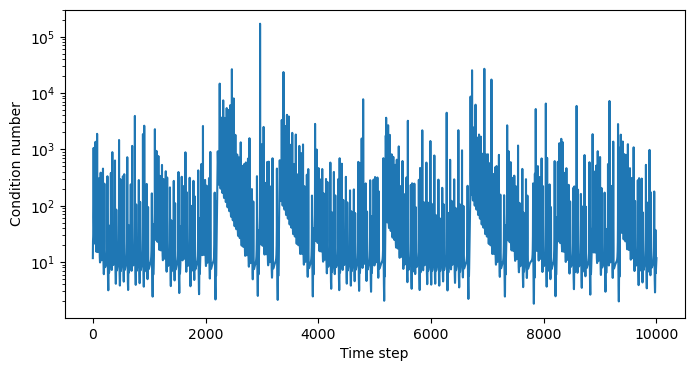

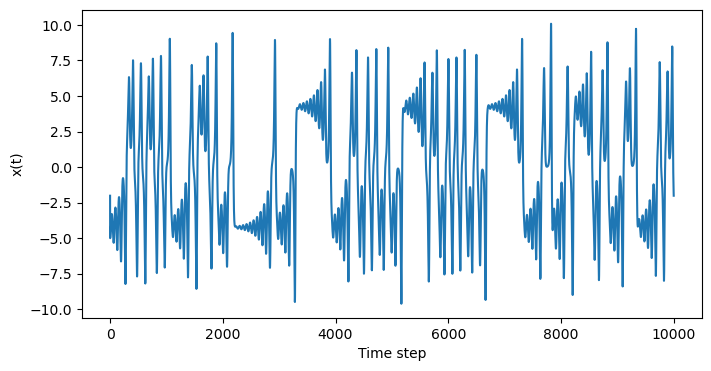

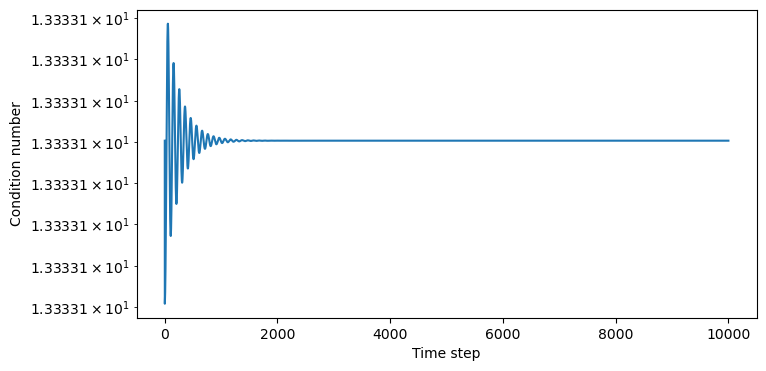

In [53]:
jac_chaotic = np.array([eq.jacobian(x) for x in x_chaotic])
plt.figure(figsize=(8, 4))
plt.semilogy(
    [np.linalg.cond(item) for item in jac_chaotic]
)
plt.xlabel("Time step")
plt.ylabel("Condition number")

plt.figure(figsize=(8, 4))
plt.plot(
    x_chaotic[:, 0]
)
plt.xlabel("Time step")
plt.ylabel("x(t)")

## Why???
# plt.figure(figsize=(6, 6))
# plt.scatter(
#     x_chaotic[:, 0], x_chaotic[:, 2], c=[np.log10(np.linalg.cond(item)) for item in jac_chaotic]
# )
# plt.xlabel("x(t)")
# plt.ylabel("y(t)")

jac_nonchaotic = np.array([eq.jacobian(x) for x in x_nonchaotic])
plt.figure(figsize=(8, 4))
plt.semilogy(
    [np.linalg.cond(item) for item in jac_nonchaotic[:]]
)
plt.xlabel("Time step")
plt.ylabel("Condition number")

Text(0, 0.5, 'y(t)')

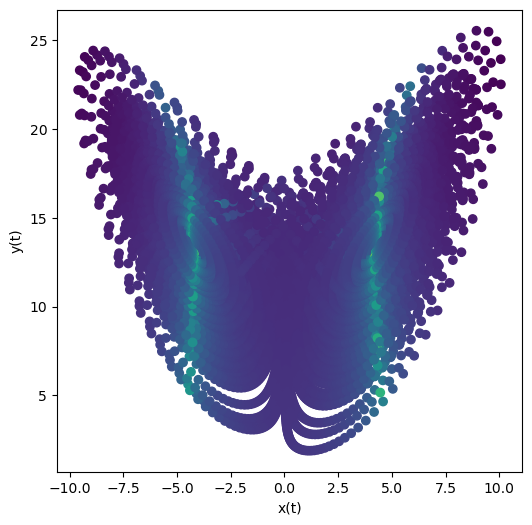

In [54]:
# plt.figure(figsize=(8, 4))
# plt.plot(
#     x_chaotic[:, 0]
# )
# plt.xlabel("Time step")
# plt.ylabel("x(t)")

## Why???
plt.figure(figsize=(6, 6))
plt.scatter(
    x_chaotic[:, 0], x_chaotic[:, 2], c=[np.log10(np.linalg.cond(item)) for item in jac_chaotic]
)
plt.xlabel("x(t)")
plt.ylabel("y(t)")


## Questions

+ In the nonchaotic case, why is the condition number still a positive, albeit smaller, number? What physical circumstances might decrease this number?

+ In higher dimensioins, it's easier to become ill-conditioned
+ In higher dimenisons there are more route to chaos

## Preconditioning

The goal of preconditioning is to transform a linear matrix equation into a better-conditioned problem by using domain knowledge to convert the problem into a more favorable set of coordinates. For example, if an elasticity problem is ill-conditioned due to a soft mode, we can rotate our measurement coordinates into a new basis centered on the soft mode, and then solve the problem in the new basis. A similar concept applies in other fields. For example, when simulating partial differential equations, spectral methods convert the spatial coordinates into a basis of orthogonal Fourier modes. This serves to precondition the problem, and is the reason why spectral methods are so much more stabke than finite-difference methods.

A similar idea arises in machine learning, where using domain knowledge to select appropriate features can greatly reduce the hypothesis space of possible models. However, selecting such features requires specific knowledge about the problem, and is known as an "inductive bias".

As an example of preconditioning, for a linear problem we might seek the "left" preconditioning matrix $Q$
$$
    A \mathbf{x} = \mathbf{y}           \\
    Q A \mathbf{x} = Q \mathbf{y}       \\
    \mathbf{x} = (Q A)^{-1} Q \mathbf{y}  \\
$$
Hopefully, $(Q A)^{-1}$ is easier to compute than $A^{-1}$


In [37]:
## Make a high condition number matrix
np.random.seed(1)
a1 = np.random.random(4)
a = np.vstack([a1, a1, a1, a1]) 
a += np.random.random(a.shape) * 1e-5
print("Full condition number of A:", condition_number(a), "\n")

## partial condition number
q = 1 / a1 * np.eye(4)

print("Condition number of Q A:", condition_number(q @ a.T), "\n")


Full condition number of A: 2228850.721433524 

Condition number of Q A: 1927294.2970319565 



# Jacobi preconditioning


Another option is to perform the preconditioning in a different order
$$
A \mathbf{x} = \mathbf{y}           \\
A P^{-1} P \mathbf{x} = \mathbf{y}  \\
$$
where we first solve for a latent variable $\mathbf{z}$
$$
\mathbf{z} = (A P^{{-1}})^{-1} \mathbf{y}
$$
And then separately solve for the unknown $\mathbf{x}$
$$
\mathbf{x} = P^{-1} \mathbf{z}
$$

There are many heuristics for choosing $Q$ or $P$ depending on the problem. Some common ones are listed [here](https://web.ma.utexas.edu/CNA/NSPCG/manuals/usernsp/node7.html). Conceptually, one of the simplest approaches is Jacobi preconditioning, where we choose $P$ to be a diagonal matrix with the same diagonal elements as $A$.

$$
P = \text{diag}(A)
$$

$$
P^{-1} = \text{diag}(A)^{-1}
$$

Recall that inverting a diagonal matrix only takes $\mathcal{O}(N)$ time, because we only have to invert each diagonal element. This is much faster than the $\mathcal{O}(N^3)$ time required to invert a general matrix.


The concept of preconditioning motivates change of basis and spectral methods for solving partial differential equations---even though many integral transforms are information-preserving and thus equivalent to a change of basis, they can be used to transform a problem into a better-conditioned form.

In [316]:
## Make a high condition number matrix
a1 = np.random.random(4)
a = np.vstack([a1, a1, a1, a1]) 
a += np.random.random(a.shape) * 1e-5
print("Full condition number:", condition_number(a), "\n")

# This is called Jacobi conditioning
p = np.identity(a.shape[0]) * np.diag(a)
pinv = np.identity(a.shape[0]) * 1 / np.diag(a) # Inverse of diagonal matrix easy to calculate

print("Partial condition number 1: ", condition_number(a @ pinv))
print("Partial condition number 2: ", condition_number(p))


Full condition number: 3479763.5582248624 

Partial condition number 1:  3055250.443096764
Partial condition number 2:  4.479215399524707


# How much does the condition number affect matrix inversion in practice?

We will generate a large number of random matrices of varying condition number, and then solve the matrix inversion problem for each matrix numerically using numpy's built-in matrix inversion routine. We will measure the wall time taken to solve the problem for each matrix, and plot the results.

Text(0, 0.5, 'Time without preconditioning')

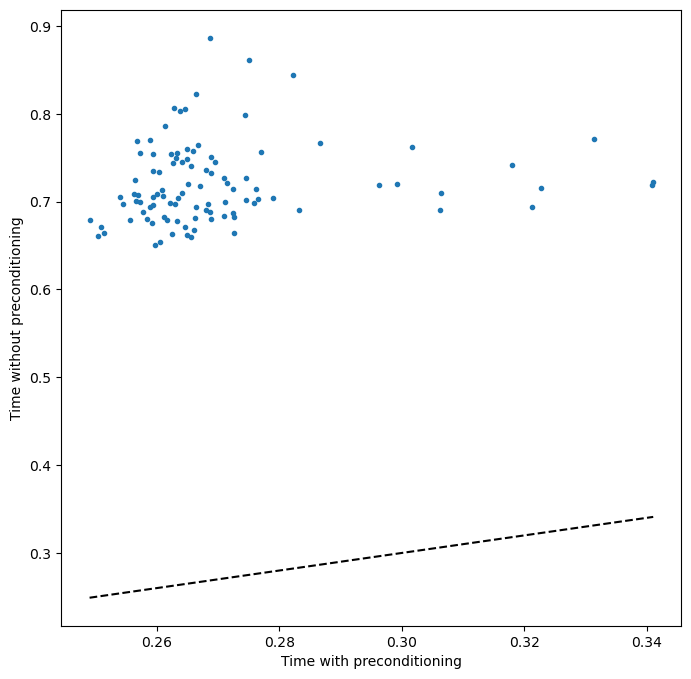

In [149]:

n_trials = 100
time_without_precond = []
time_with_precond = []
for _ in range(n_trials):
    # Generate a random matrix and a random vector
    A = np.random.rand(4000, 4000)
    b = np.random.rand(4000)

    # Measure the time to solve the system
    start_time = time.time()
    sol = np.linalg.solve(A, b)
    # Ainv = np.linalg.inv(A)
    # sol = Ainv @ b
    end_time = time.time()
    time_taken = end_time - start_time
    time_without_precond.append(time_taken)

    # Now let's try preconditioning
    P = np.identity(A.shape[0]) * 1 / np.diag(A)
    start_time = time.time()
    A_precond = P @ A
    b_precond = P @ b
    sol = np.linalg.solve(A_precond, b_precond)
    end_time = time.time()
    time_taken = end_time - start_time
    time_with_precond.append(time_taken)

plt.figure(figsize=(8, 8))
plt.plot(time_without_precond, time_with_precond, '.')
plt.plot(np.sort(time_without_precond), np.sort(time_without_precond), '--k', label="Equal runtime")
# plt.xlim(np.min(time_without_precond), np.max(time_without_precond))
# plt.ylim(np.min(time_without_precond), np.max(time_without_precond))
plt.xlabel("Time with preconditioning")
plt.ylabel("Time without preconditioning")





We can see that preconditioning the matrix leads to a much faster solution.

## Questions

+ Why doesn't numpy automatically precondition matrices before inverting them?

<br>
<br>
<br>
<br>
<br>
<br>
<br>